In [1]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
from matplotlib import colormaps 
import seaborn as sns
#https://github.com/vinsburg/alluvial_diagram
import alluvial
from collections import Counter
import copy

In [2]:
client = bigquery.Client(project='subugoe-wag-closed')

In [3]:
s2ag_papers = 'subugoe-wag-closed.S2AG.papers'

In [4]:
sns.set_style('whitegrid')
plt.rc('font', family='Arial')
plt.rc('font', size=9) 
plt.rc('axes', titlesize=9) 
plt.rc('axes', labelsize=9) 
plt.rc('xtick', labelsize=9) 
plt.rc('ytick', labelsize=9) 
plt.rc('legend', fontsize=9)

## Abdeckung von DOIs

In [44]:
df_doi = client.query(f"""
                       SELECT COUNT(DISTINCT(externalids.DOI)) AS number_of_dois, 
                              COUNT(DISTINCT(corpusid)) AS number_of_publications, 
                              EXTRACT (YEAR FROM publicationdate) AS year
                       FROM {s2ag_papers} 
                       GROUP BY year
                       ORDER BY year DESC
                       """).to_dataframe()

In [50]:
df_doi['number_of_dois'].sum()

114924476

In [51]:
df_doi['number_of_publications'].sum()

210579294

In [6]:
df_doi_2000 = df_doi[df_doi.year > 2000]

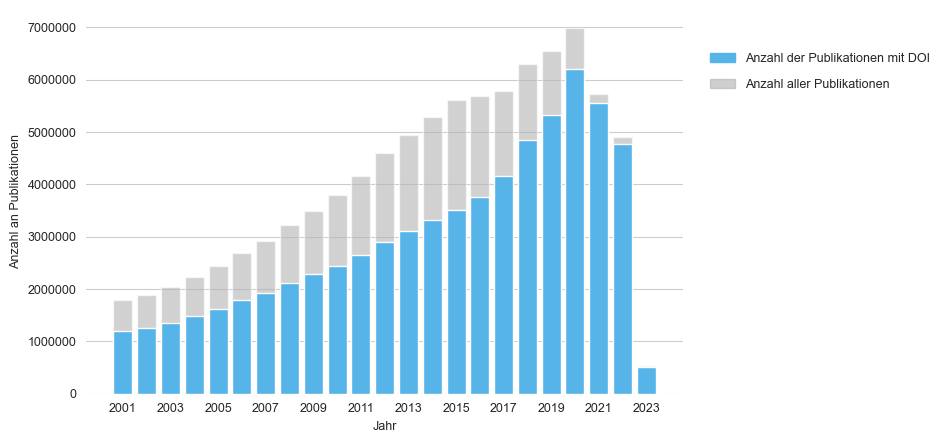

In [7]:
fig, ax = plt.subplots(figsize=(7,4.5))
plt.box(False)

sns.barplot(data=df_doi_2000, 
            x='year', 
            y='number_of_publications', 
            alpha=0.6,
            color='#b3b3b3a0',
            saturation=1,
            errorbar=None)

sns.barplot(data=df_doi_2000, 
            x='year', 
            y='number_of_dois', 
            alpha=1,
            color='#56B4E9',
            saturation=1,
            errorbar=None)

plt.locator_params(nbins=12, axis='x')
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f'))

ax.set(xlabel='Jahr', ylabel='Anzahl an Publikationen')

doi_patch = mpatches.Patch(color='#56B4E9', label='Anzahl der Publikationen mit DOI')
not_doi_patch = mpatches.Patch(color='#b3b3b3a0', label='Anzahl aller Publikationen')

lgd = fig.legend(handles=[doi_patch, not_doi_patch], frameon=False,
                 bbox_to_anchor=(1.35, 0.9), labelspacing=1.1)

plt.tight_layout()

plt.show()

## Abdeckung von Publikationstypen

In [5]:
df_types_single = client.query(f"""
                                SELECT type, COUNT(DISTINCT(corpusid)) AS number_of_publications
                                FROM (
                                     SELECT DISTINCT type, corpusid
                                     FROM {s2ag_papers}, UNNEST(publicationtypes) as type 
                                     )
                                GROUP BY type
                                """).to_dataframe()

In [6]:
df_types_single

,type,number_of_publications
0,Editorial,656743
1,Study,2341438
2,JournalArticle,39583455
3,CaseReport,2175516
4,News,238177
5,MetaAnalysis,103671
6,LettersAndComments,1539429
7,ClinicalTrial,582157
8,Dataset,727
9,Book,274375


In [7]:
df_types_agg = client.query(f"""
                             SELECT ARRAY_TO_STRING(publicationtypes, ",") AS types, 
                                    COUNT(DISTINCT(corpusid)) AS number_of_publications
                             FROM {s2ag_papers}
                             GROUP BY types
                             ORDER BY number_of_publications DESC
                             """).to_dataframe()

In [8]:
df_types_agg

,types,number_of_publications
0,,157488277
1,JournalArticle,28452480
2,Review,8790961
3,"Review,JournalArticle",2645627
4,Conference,2254022
...,...,...
615,"LettersAndComments,ClinicalTrial,Editorial",1
616,"JournalArticle,ClinicalTrial,LettersAndComment...",1
617,"MetaAnalysis,JournalArticle,ClinicalTrial,Case...",1
618,"Review,Study,Editorial,ClinicalTrial",1


In [9]:
df_types_agg['types'] = df_types_agg['types'].apply(lambda x: x.split(','))

In [10]:
types_dict_count = Counter(
    Dataset=0,
    MetaAnalysis=0,
    Book=0,
    News=0,
    Conference=0,
    LettersAndComments=0,
    ClinicalTrial=0,
    Editorial=0,
    JournalArticle=0,
    Study=0,
    CaseReport=0,
    Review=0
)

In [11]:
types_dict = dict(
    Dataset=copy.copy(types_dict_count),
    MetaAnalysis=copy.copy(types_dict_count),
    Book=copy.copy(types_dict_count),
    News=copy.copy(types_dict_count),
    Conference=copy.copy(types_dict_count),
    LettersAndComments=copy.copy(types_dict_count),
    ClinicalTrial=copy.copy(types_dict_count),
    Editorial=copy.copy(types_dict_count),
    JournalArticle=copy.copy(types_dict_count),
    Study=copy.copy(types_dict_count),
    CaseReport=copy.copy(types_dict_count),
    Review=copy.copy(types_dict_count)
    
)

In [12]:
def count_combinations(type_combination: list, number_of_publications: int):
    for t in type_combination:
        if t == '':
            continue
        d = types_dict[t]
        for t_count in d:
            for t2 in type_combination:
                if t2 == t_count:
                    d[t_count] += number_of_publications

In [13]:
for row in df_types_agg.to_dict('records'):
    count_combinations(row['types'], row['number_of_publications'])

In [14]:
types_dict['Dataset '] = types_dict.pop('Dataset')
types_dict['MetaAnalysis '] = types_dict.pop('MetaAnalysis')
types_dict['Book '] = types_dict.pop('Book')
types_dict['News '] = types_dict.pop('News')
types_dict['Conference '] = types_dict.pop('Conference')
types_dict['LettersAndComments '] = types_dict.pop('LettersAndComments')
types_dict['ClinicalTrial '] = types_dict.pop('ClinicalTrial')
types_dict['Editorial '] = types_dict.pop('Editorial')
types_dict['JournalArticle '] = types_dict.pop('JournalArticle')
types_dict['Study '] = types_dict.pop('Study')
types_dict['CaseReport '] = types_dict.pop('CaseReport')
types_dict['Review '] = types_dict.pop('Review')

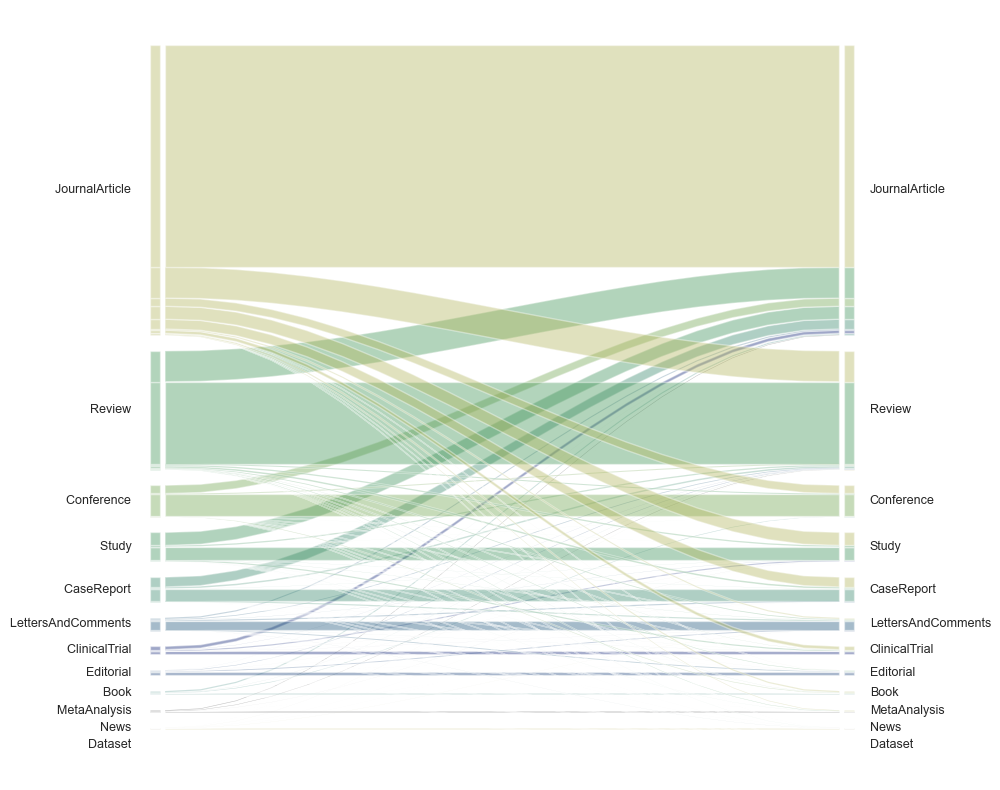

In [15]:
cmap = colormaps['gist_earth']

ax = alluvial.plot(types_dict, alpha=0.4, cmap=cmap, fontname='Arial')
fig = ax.get_figure()
fig.set_size_inches(10,10)
plt.show()

## Open Access nach Publikationstyp

In [16]:
df_types_oa = client.query(f"""
                            SELECT type, isopenaccess, year, COUNT(DISTINCT(corpusid)) AS number_of_publications
                            FROM (
                                SELECT DISTINCT type, corpusid, isopenaccess, 
                                       EXTRACT (YEAR FROM publicationdate) AS year
                                FROM {s2ag_papers}, UNNEST(publicationtypes) as type 
                                WHERE year >= 2010
                                 )
                            GROUP BY type, isopenaccess, year
                            """).to_dataframe()

In [17]:
df_types_oa = pd.merge(df_types_oa, 
                       df_types_oa.groupby(['type', 'year'])['number_of_publications'].sum().to_frame()\
                           .reset_index()\
                           .rename(columns={'number_of_publications':'number_of_total_publications'}),
                       on=['type', 'year'])

In [18]:
df_types_oa['proportion'] = df_types_oa['number_of_publications']/df_types_oa['number_of_total_publications']

In [19]:
df_types_oa

,type,isopenaccess,year,number_of_publications,number_of_total_publications,proportion
0,Study,True,2014,28342,70195,0.403761
1,Study,False,2014,41853,70195,0.596239
2,Conference,True,2013,14992,134716,0.111286
3,Conference,False,2013,119724,134716,0.888714
4,Editorial,False,2019,11317,26488,0.42725
...,...,...,...,...,...,...
312,CaseReport,False,2018,28671,47093,0.608817
313,ClinicalTrial,False,2023,42,42,1.0
314,Study,False,2022,751,751,1.0
315,Dataset,False,2023,4,4,1.0


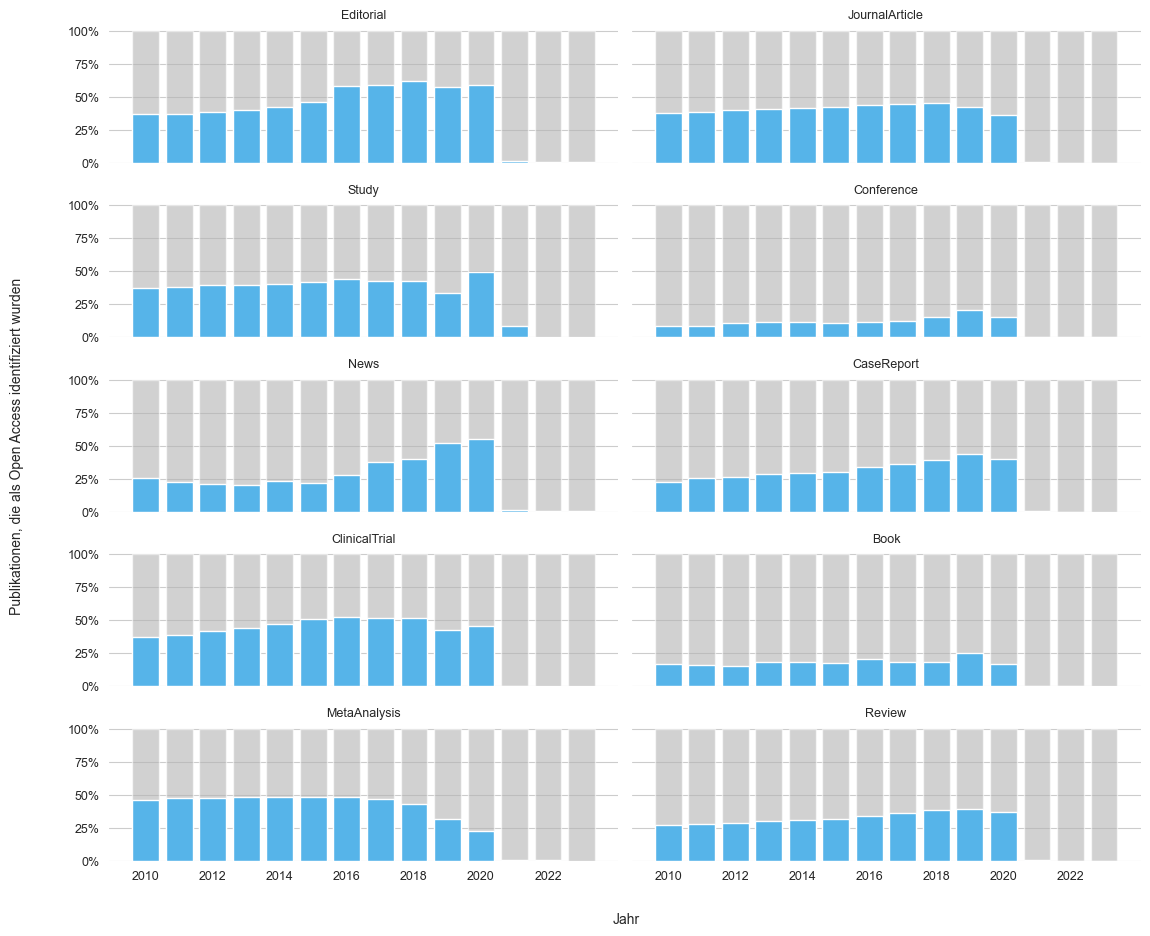

In [20]:
fig, axes = plt.subplots(nrows=5, 
                         ncols=2, 
                         sharex=True, 
                         sharey=True, 
                         figsize=(11, 9))

axes = axes.reshape(-1)

type_list = list(set(df_types_oa['type']))
type_list.remove('Dataset')
type_list.remove('LettersAndComments')

for i, ax in enumerate(axes, 1):
    pub_type = type_list[i-1]
    
    df2 = df_types_oa[df_types_oa['type'] == pub_type]
    
    sns.barplot(data=df2, 
                x='year', 
                y=[1] * len(df2),
                alpha=0.6,
                color='#b3b3b3a0',
                saturation=1,
                errorbar=None,
                ax=ax)
    
    sns.barplot(data=df2[df2.isopenaccess==True], 
                x='year', 
                y='proportion', 
                alpha=1,
                color='#56B4E9',
                saturation=1,
                errorbar=None,
                ax=ax)
    
    sns.despine(bottom = True, left = True)
    
    plt.locator_params(nbins=8, axis='x')
    
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    
    ax.set_ylabel('')    
    ax.set_xlabel('')
    
    ax.set_title(pub_type, fontdict={'fontsize': 9}, pad=4)
    
x_label = fig.text(0.52, -0.03, 'Jahr', ha='center', 
                   fontdict={'fontsize': 10})

y_label = fig.text(-0.04, 0.5, 'Publikationen, die als Open Access identifiziert wurden', va='center', 
                   rotation='vertical', fontdict={'fontsize': 10})

plt.tight_layout()

plt.show()

## Publikationstyp nach Verlag

In [21]:
df_venue = client.query(f"""
                         SELECT venue, COUNT(DISTINCT(corpusid)) AS number_of_total_publications
                         FROM {s2ag_papers}
                         GROUP BY venue
                         ORDER BY number_of_total_publications DESC
                         LIMIT 20
                         """).to_dataframe()

In [22]:
df_venue

,venue,number_of_total_publications
0,,144717004
1,Nature,421802
2,PLoS ONE,274163
3,Science,273596
4,Scientific Reports,220588
5,SSRN Electronic Journal,217401
6,ArXiv,215815
7,Journal of Biological Chemistry,190552
8,The Lancet,178665
9,bioRxiv,164477


In [23]:
df_venue_type = client.query(f"""
                              SELECT venue, COUNT(DISTINCT(corpusid)) AS number_of_publications, type
                              FROM (
                                 SELECT DISTINCT type, venue, corpusid
                                 FROM {s2ag_papers}, UNNEST(publicationtypes) as type 
                              )
                              GROUP BY venue, type
                              ORDER BY number_of_publications DESC
                              """).to_dataframe()

In [24]:
df_venue_type_sum = df_venue_type.groupby(['venue'])['number_of_publications'].sum().reset_index()\
                                .sort_values(by='number_of_publications', ascending=False).head(20)
df_venue_type_sum.rename(columns={'number_of_publications': 'number_of_total_publications'}, inplace=True)

In [25]:
#df_venue_type_merged = pd.merge(df_venue, df_venue_type, on=['venue'])
df_venue_type_merged = pd.merge(df_venue_type_sum, df_venue_type, on=['venue'])

In [26]:
df_venue_type_merged['proportion'] = (df_venue_type_merged['number_of_publications'])/\
                                        (df_venue_type_merged['number_of_total_publications']) * 100

df_venue_type_merged['proportion'] = df_venue_type_merged['proportion'].apply(lambda x: '{0:.2f}'.format(x))

In [27]:
df_venue_type_merged

,venue,number_of_total_publications,number_of_publications,type,proportion
0,,8366837,7332570,Review,87.64
1,,8366837,957882,JournalArticle,11.45
2,,8366837,32098,Editorial,0.38
3,,8366837,26876,Book,0.32
4,,8366837,9221,LettersAndComments,0.11
...,...,...,...,...,...
161,International Journal of Environmental Researc...,75213,376,Editorial,0.50
162,International Journal of Environmental Researc...,75213,374,CaseReport,0.50
163,International Journal of Environmental Researc...,75213,159,MetaAnalysis,0.21
164,International Journal of Environmental Researc...,75213,74,LettersAndComments,0.10


In [28]:
df_venue_type_merged.venue.replace('', 'Venue unknown', inplace=True)
df_venue_type_merged.type.replace('', 'Type unknown', inplace=True)

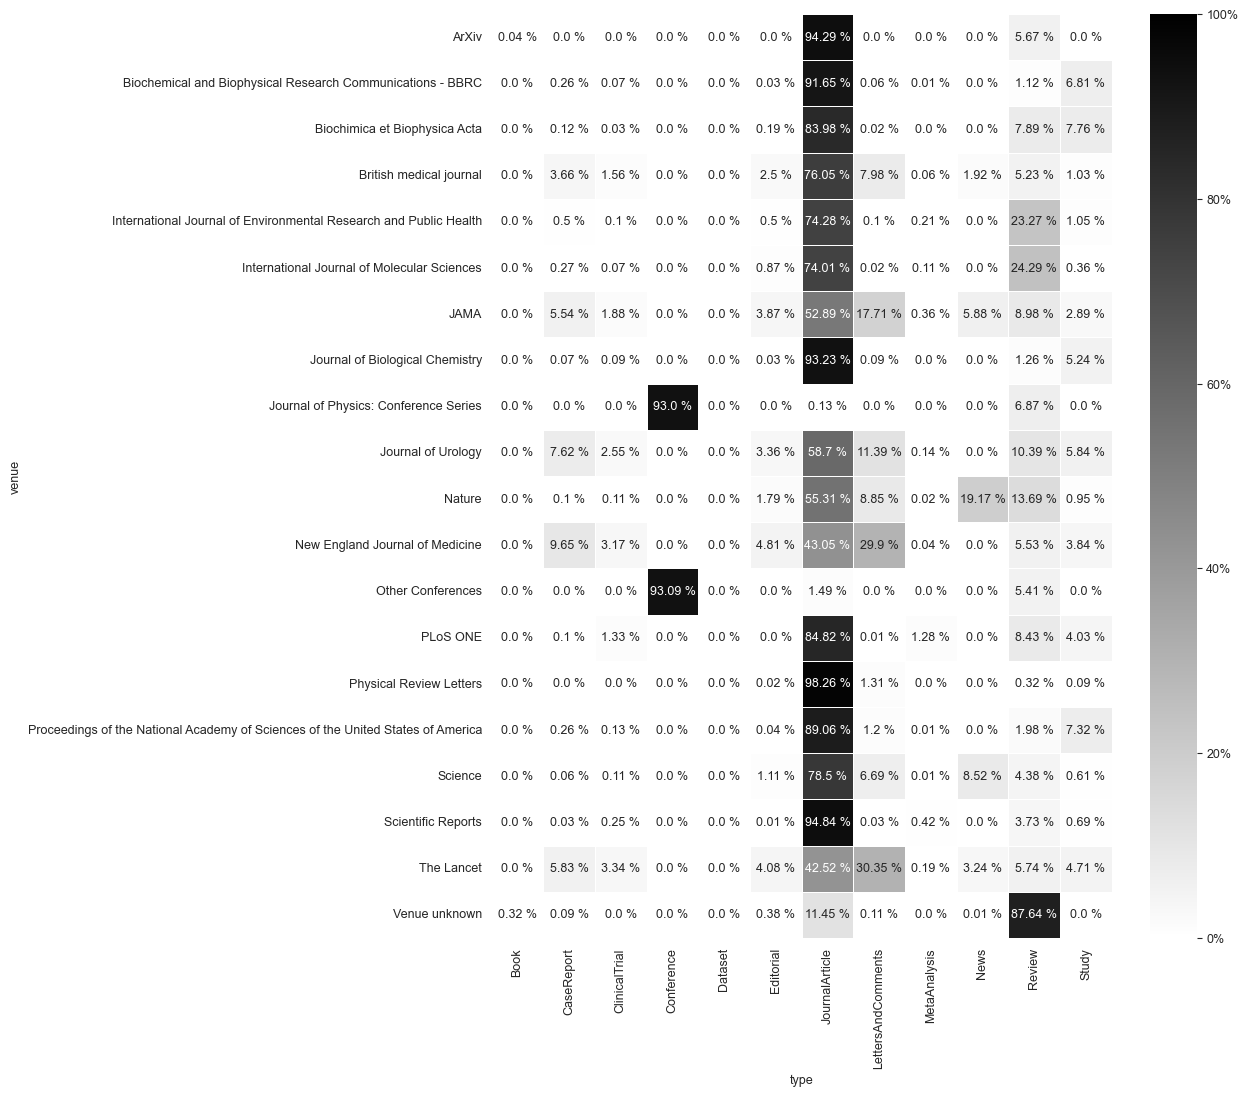

In [29]:
df_heatmap = pd.pivot_table(df_venue_type_merged, 
                            index='venue', 
                            columns='type', 
                            values='proportion', 
                            fill_value=float(0))

fig, ax = plt.subplots(figsize=(10, 12))
ax1 = sns.heatmap(df_heatmap, 
                  cbar_kws={'format': '%.0f%%'},
                  fmt='',
                  cmap=plt.get_cmap('binary'),
                  annot=True,
                  linewidths=.5,
                  vmin=0,
                  vmax=100,
                  ax=ax)

for t in ax1.texts: t.set_text(t.get_text() + ' %')
plt.show()

## Abdeckung nach Fachgebieten

In [33]:
df_fields = client.query(f"""
                          SELECT category, 
                                 COUNT(DISTINCT(corpusid)) AS number_of_publications
                          FROM (
                              SELECT DISTINCT corpusid, field.category AS category
                              FROM {s2ag_papers}, UNNEST(s2fieldsofstudy) as field 
                          )
                          GROUP BY category
                          ORDER BY number_of_publications DESC
                          """).to_dataframe()

In [34]:
df_fields['number_of_total_publications'] = df_fields['number_of_publications'].sum()
df_fields['proportion'] = (df_fields['number_of_publications']/df_fields['number_of_total_publications']) * 100
df_fields['proportion'] = df_fields['proportion'].apply(lambda x: '{0:.2f}'.format(x))

In [35]:
df_fields

,category,number_of_publications,number_of_total_publications,proportion
0,Medicine,48826489,221067398,22.09
1,Biology,23867955,221067398,10.80
2,Chemistry,15700183,221067398,7.10
3,Computer Science,15280707,221067398,6.91
4,Engineering,14278168,221067398,6.46
5,Physics,13207141,221067398,5.97
6,Materials Science,12443360,221067398,5.63
7,Psychology,9938943,221067398,4.50
8,Environmental Science,7329628,221067398,3.32
9,Business,7183939,221067398,3.25


In [36]:
df_fields_venue = client.query(f"""
                                SELECT venue, category, COUNT(DISTINCT(corpusid)) AS number_of_publications
                                FROM (
                                    SELECT DISTINCT corpusid, venue, field.category AS category, 
                                    FROM {s2ag_papers}, UNNEST(s2fieldsofstudy) as field 
                                )
                                GROUP BY venue, category
                                ORDER BY number_of_publications DESC
                                """).to_dataframe()

In [37]:
df_fields_venue

,venue,category,number_of_publications
0,,Medicine,13627013
1,,Engineering,10793780
2,,Chemistry,10004021
3,,Physics,9979422
4,,Materials Science,9509290
...,...,...,...
1272854,Journal of Private Equity,Psychology,1
1272855,Gyógyszereink,Biology,1
1272856,Soils as a Key Component of the Critical Zone 6,Geography,1
1272857,Terrestrial Mammal Conservation,History,1


In [38]:
df_fields_venue_sum = df_fields_venue.groupby(['venue'])['number_of_publications'].sum().reset_index()\
                                .sort_values(by='number_of_publications', ascending=False).head(20)
df_fields_venue_sum.rename(columns={'number_of_publications': 'number_of_total_publications'}, inplace=True)

In [39]:
df_fields_venue_merged = pd.merge(df_fields_venue_sum, df_fields_venue, on=['venue'])

In [40]:
df_fields_venue_merged['proportion'] = (df_fields_venue_merged['number_of_publications'])/\
                                        (df_fields_venue_merged['number_of_total_publications']) * 100

df_fields_venue_merged['proportion'] = df_fields_venue_merged['proportion'].apply(lambda x: '{0:.1f}'.format(x))

In [41]:
df_fields_venue_merged.venue.replace('', 'Venue unknown', inplace=True)

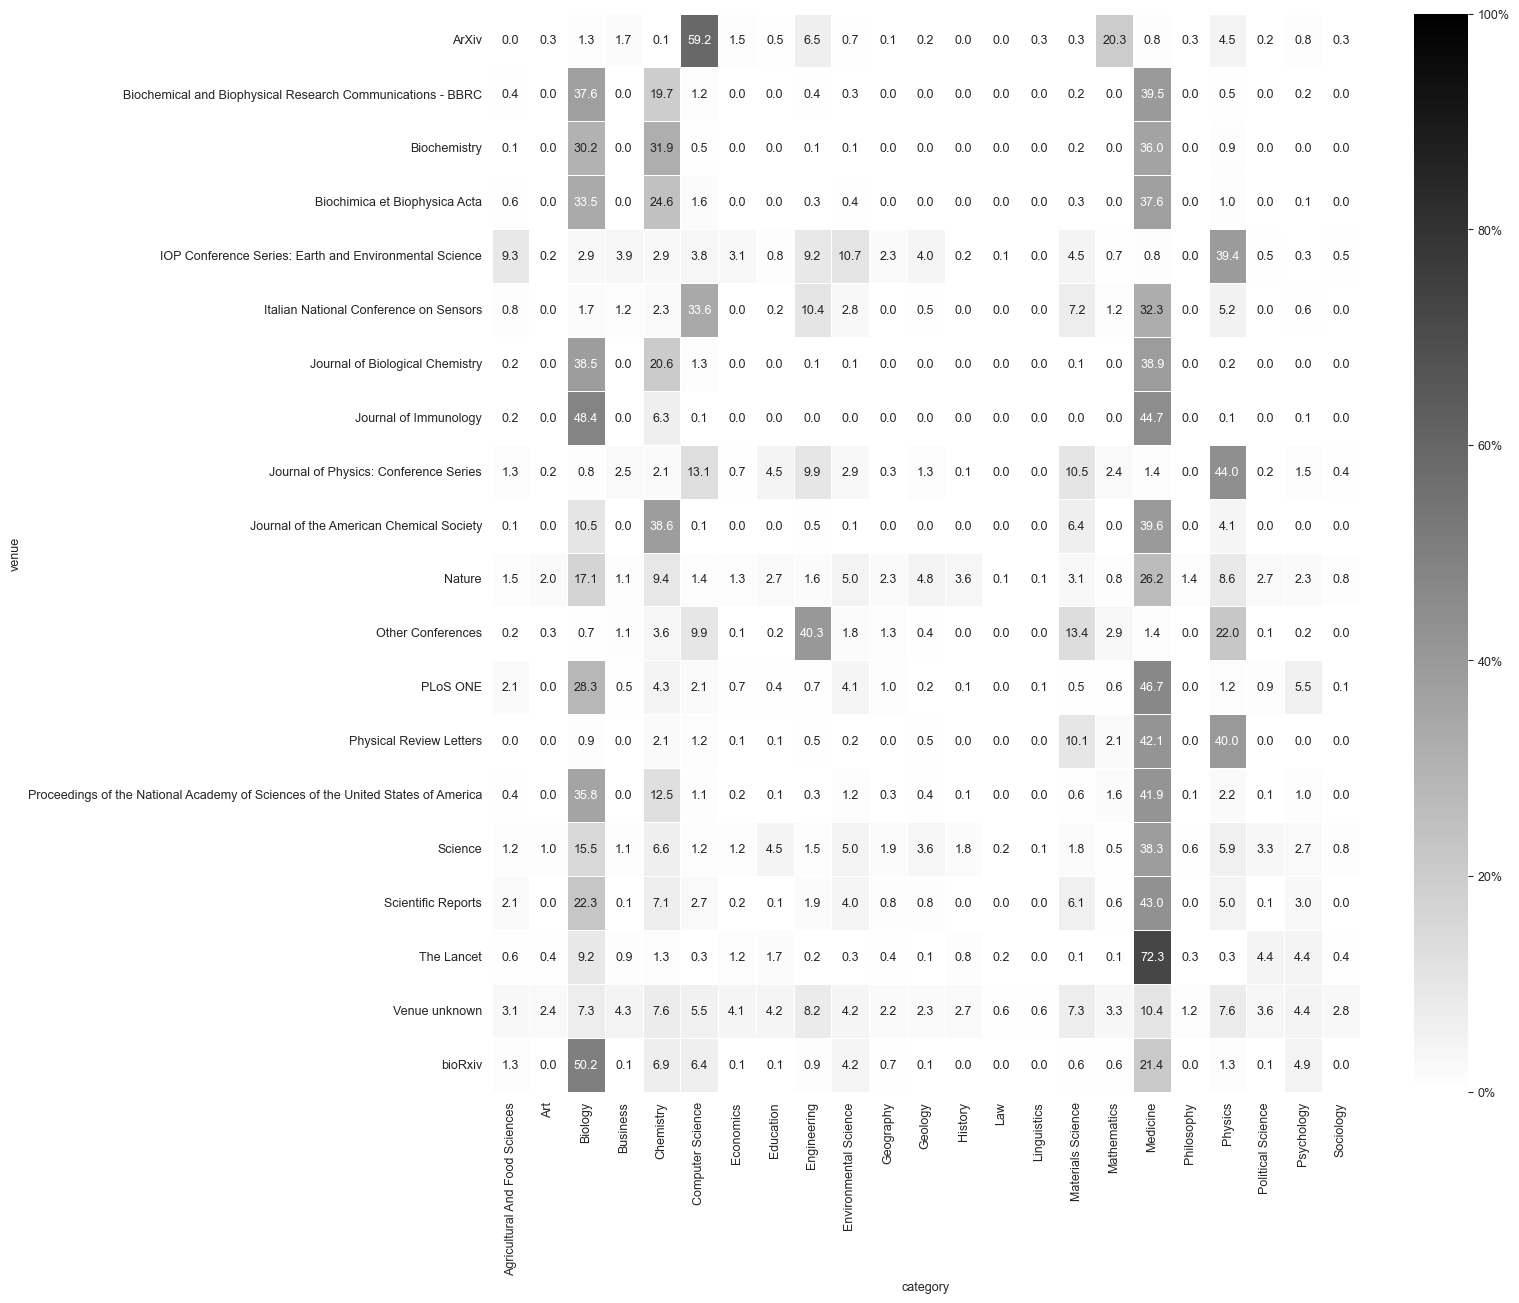

In [42]:
df_heatmap_venue_fields = pd.pivot_table(df_fields_venue_merged, 
                                         index='venue', 
                                         columns='category', 
                                         values='proportion', 
                                         fill_value=float(0))

fig, ax = plt.subplots(figsize=(14, 14))
ax1 = sns.heatmap(df_heatmap_venue_fields, 
                  cbar_kws={'format': '%.0f%%'},
                  fmt='',
                  cmap=plt.get_cmap('binary'),
                  annot=True,
                  linewidths=.5,
                  vmin=0,
                  vmax=100,
                  ax=ax)

#for t in ax1.texts: t.set_text(t.get_text() + ' %')
plt.show()

In [ ]:
#SELECT DISTINCT STRING_AGG(fields.category, ",")
#FROM `subugoe-wag-closed.S2AG.papers`, UNNEST(s2fieldsofstudy) AS fields 
#WHERE corpusid = 234301870